<a href="https://colab.research.google.com/github/minddo/Personalized_emotion_recognition/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

다음은 입력길이 30초에 대한 모델링이다

In [1]:
import pickle
import numpy as np
dataset=pickle.load(open('/content/drive/My Drive/KEMOC/dataset_30.pkl', 'rb'), encoding='iso-8859-1')

120


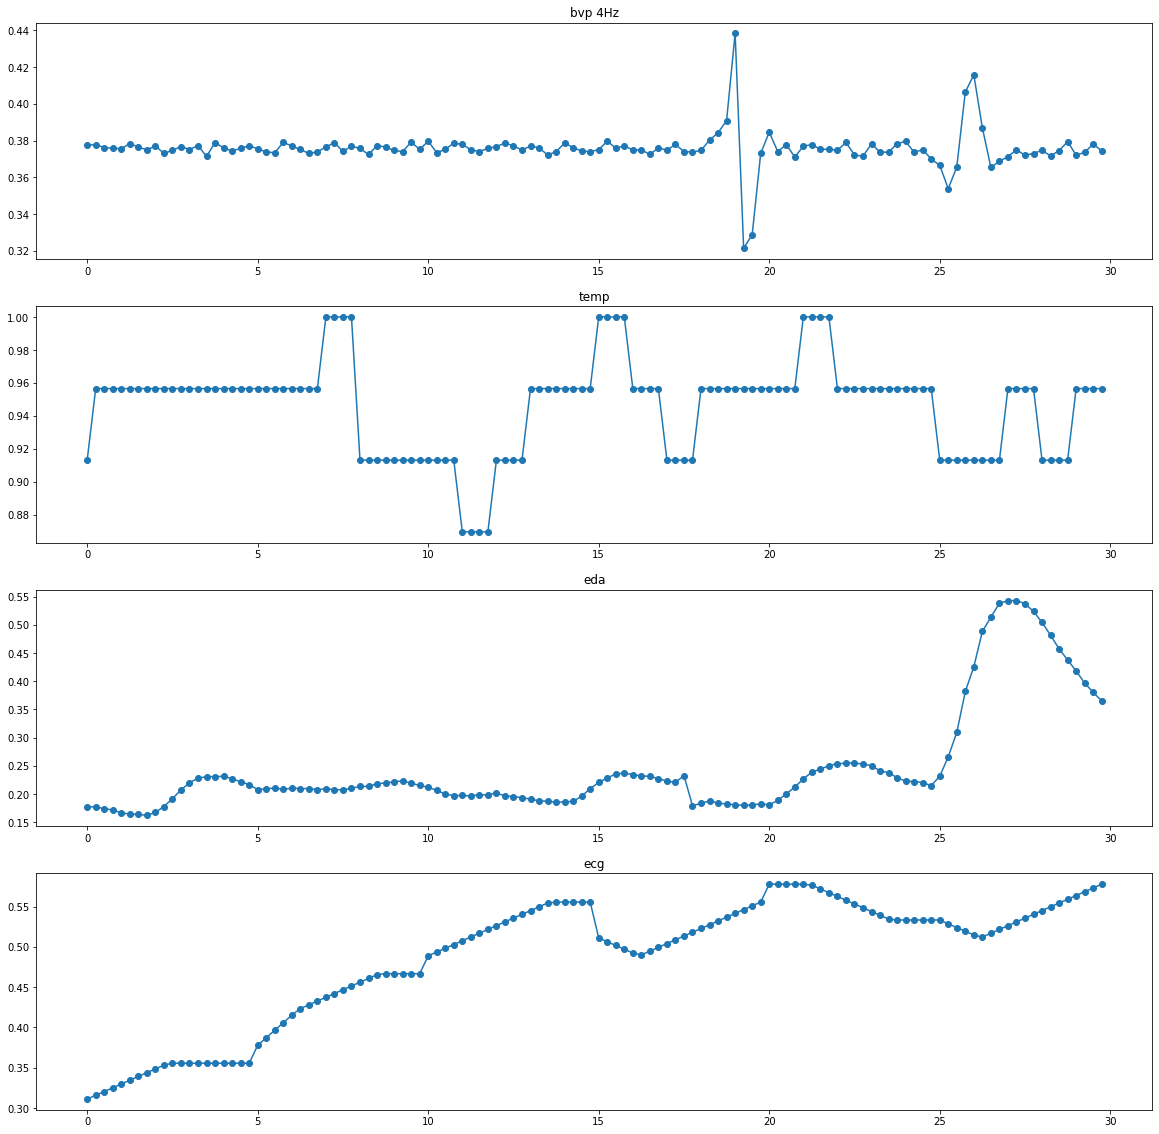

In [2]:
data=dataset['p1']['data']
import numpy as np
import matplotlib.pyplot as plt

t2=np.arange(0.,30.,1/4)
print(len(t2))
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)
plt.plot(t2, data['bvp'][0], 'o-')
plt.title('bvp 4Hz')


plt.subplot(4, 1, 2)
plt.plot(t2, data['temp'][0], 'o-')
plt.title('temp')



plt.subplot(4, 1, 3)
plt.plot(t2, data['eda'][0], 'o-')
plt.title('eda')



plt.subplot(4, 1, 4)
plt.plot(t2, data['ecg'][0], 'o-')
plt.title('ecg')



plt.show()

#Model and hyperparameter

In [3]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 120
input_size = 4
hidden_size = 32
num_layers = 2
num_classes = 2
batch_size = 256
num_epochs = 500
learning_rate = 0.05

In [5]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Model per subject

개인의 데이터를 이용하여 개인마다 1개의 모델을 만든다. 만약 레이블이 한 쪽 밖에 없는 유저에 대해서는 모델링에서 제외한다.

In [9]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
n_split=3

## Arousal

In [6]:
# 레이블이 하나밖에 존재하지 않는 참가자 제거
removed_dataset={}

for ID in dataset.keys():
    if ID=='p22' or ID=='p27' or ID=='p8' or ID=='p26' or ID=='p32':
        continue
    else:
        removed_dataset[ID]={"data":dataset[ID]['data'], "labels":dataset[ID]['labels']}

In [24]:
acc_list=[]
f1_list=[]
roc_list=[]
for ID in removed_dataset.keys():
    print(ID)
    X=np.concatenate((np.array(dataset[ID]['data']['bvp']).reshape(-1,120,1),np.array(dataset[ID]['data']['eda']).reshape(-1,120,1), np.array(dataset[ID]['data']['temp']).reshape(-1,120,1), np.array(dataset[ID]['data']['ecg']).reshape(-1,120,1)), axis=2)
    Y=dataset[ID]['labels']['self_arousal']
    Y=np.array([item[0] for item in Y])
    X=torch.Tensor(X)
    Y=torch.Tensor(Y).long()

    acc=[]
    f1=[]
    roc=[]
    for train_index,test_index in StratifiedKFold(n_splits=3).split(X,Y):
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]
        train_loader = torch.utils.data.DataLoader(TensorDataset(x_train,y_train), batch_size=batch_size)
        test_loader = torch.utils.data.DataLoader(TensorDataset(x_test,y_test), batch_size=batch_size)

        model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
        weight=[len([x for x in y_train if x==0])/len(y_train), len([x for x in y_train if x==1])/len(y_train)]
        class_weight = torch.FloatTensor(weight).cuda()

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss(weight=class_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # train

        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images = images.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if epoch%100==0:
                    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs , loss.item()))

        PATH = '/content/drive/My Drive/KEMOC/MULTI_MODAL/PERSONAL_MODEL/AROUSAL/'
        torch.save(model, PATH + 'model_'+ID+'.pt')  
        # test

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
        
        acc.append(accuracy_score(labels.cpu(), predicted.cpu(),)*100)
        f1.append(f1_score(labels.cpu(), predicted.cpu().long())*100)
        roc.append(roc_auc_score( labels.cpu(), predicted.cpu())*100)

    
    acc_list.append(np.mean(acc))
    f1_list.append(np.mean(f1))
    roc_list.append(np.mean(roc))
    print(acc_list)
    print(f1_list)
    print(roc_list)

p16
Epoch [1/500], Loss: 0.6386
Epoch [101/500], Loss: 0.2425
Epoch [201/500], Loss: 0.0931
Epoch [301/500], Loss: 0.0768
Epoch [401/500], Loss: 0.0519
Epoch [1/500], Loss: 0.6485
Epoch [101/500], Loss: 0.1861
Epoch [201/500], Loss: 0.1773
Epoch [301/500], Loss: 0.0988
Epoch [401/500], Loss: 0.0008
Epoch [1/500], Loss: 0.7396
Epoch [101/500], Loss: 0.0002
Epoch [201/500], Loss: 0.0001
Epoch [301/500], Loss: 0.0001
Epoch [401/500], Loss: 0.0000
[71.05263157894736]
[33.9031339031339]
[62.142857142857146]
p10
Epoch [1/500], Loss: 0.6956
Epoch [101/500], Loss: 0.4447
Epoch [201/500], Loss: 0.3310
Epoch [301/500], Loss: 0.1216
Epoch [401/500], Loss: 0.4366
Epoch [1/500], Loss: 0.6913
Epoch [101/500], Loss: 0.2101
Epoch [201/500], Loss: 0.1729
Epoch [301/500], Loss: 0.1191
Epoch [401/500], Loss: 0.3193
Epoch [1/500], Loss: 0.7037
Epoch [101/500], Loss: 0.6140
Epoch [201/500], Loss: 0.3622
Epoch [301/500], Loss: 0.0168
Epoch [401/500], Loss: 0.0164
[71.05263157894736, 61.30867709815078]
[33.9

In [25]:
print(np.mean(acc_list))
print(np.mean(f1_list))
print(np.mean(roc_list))

70.03588089749621
49.25384551351268
61.04413630031122


## Valence

In [37]:
# 레이블이 하나밖에 존재하지 않는 참가자 제거
removed_dataset={}

for ID in dataset.keys():
    if ID=='p5' or  ID=='p11' or ID=='p16' or ID=='p19' or ID=='p24' or ID=='p25':
        continue
    else:
        removed_dataset[ID]={"data":dataset[ID]['data'], "labels":dataset[ID]['labels']}

In [27]:
acc_list=[]
f1_list=[]
roc_list=[]
for ID in removed_dataset.keys():
    print(ID)
    X=np.concatenate((np.array(dataset[ID]['data']['bvp']).reshape(-1,120,1),np.array(dataset[ID]['data']['eda']).reshape(-1,120,1), np.array(dataset[ID]['data']['temp']).reshape(-1,120,1), np.array(dataset[ID]['data']['ecg']).reshape(-1,120,1)), axis=2)
    Y=dataset[ID]['labels']['self_valence']
    Y=np.array([item[0] for item in Y])
    X=torch.Tensor(X)
    Y=torch.Tensor(Y).long()

    acc=[]
    f1=[]
    roc=[]
    for train_index,test_index in StratifiedKFold(n_splits=3).split(X,Y):
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]
        train_loader = torch.utils.data.DataLoader(TensorDataset(x_train,y_train), batch_size=batch_size)
        test_loader = torch.utils.data.DataLoader(TensorDataset(x_test,y_test), batch_size=batch_size)

        model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
        weight=[len([x for x in y_train if x==0])/len(y_train), len([x for x in y_train if x==1])/len(y_train)]
        class_weight = torch.FloatTensor(weight).cuda()

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss(weight=class_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # train

        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images = images.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if epoch%100==0:
                    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs , loss.item()))

        PATH = '/content/drive/My Drive/KEMOC/MULTI_MODAL/PERSONAL_MODEL/VALENCE/'
        torch.save(model, PATH + 'model_'+ID+'.pt')  
        # test

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
        
        acc.append(accuracy_score(labels.cpu(), predicted.cpu(),)*100)
        f1.append(f1_score(labels.cpu(), predicted.cpu().long())*100)
        roc.append(roc_auc_score( labels.cpu(), predicted.cpu())*100)

    
    acc_list.append(np.mean(acc))
    f1_list.append(np.mean(f1))
    roc_list.append(np.mean(roc))
    print(acc_list)
    print(f1_list)
    print(roc_list)

p10
Epoch [1/500], Loss: 0.6929
Epoch [101/500], Loss: 0.3728
Epoch [201/500], Loss: 0.4401
Epoch [301/500], Loss: 0.4160
Epoch [401/500], Loss: 0.4736
Epoch [1/500], Loss: 0.6937
Epoch [101/500], Loss: 0.4855
Epoch [201/500], Loss: 0.4026
Epoch [301/500], Loss: 0.3651
Epoch [401/500], Loss: 0.2291
Epoch [1/500], Loss: 0.6950
Epoch [101/500], Loss: 0.2776
Epoch [201/500], Loss: 0.4367
Epoch [301/500], Loss: 0.0428
Epoch [401/500], Loss: 0.0622
[56.59080132764344]
[39.41273779983458]
[56.140350877192986]
p23
Epoch [1/500], Loss: 0.6840
Epoch [101/500], Loss: 0.2734
Epoch [201/500], Loss: 0.1835
Epoch [301/500], Loss: 0.2965
Epoch [401/500], Loss: 0.0744
Epoch [1/500], Loss: 0.6639
Epoch [101/500], Loss: 0.5215
Epoch [201/500], Loss: 0.4826
Epoch [301/500], Loss: 0.3470
Epoch [401/500], Loss: 0.4223
Epoch [1/500], Loss: 0.6701
Epoch [101/500], Loss: 0.4100
Epoch [201/500], Loss: 0.3115
Epoch [301/500], Loss: 0.3139
Epoch [401/500], Loss: 0.2855
[56.59080132764344, 61.40350877192983]
[39.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


ValueError: ignored

In [28]:
print(np.mean(acc_list))
print(np.mean(f1_list))
print(np.mean(roc_list))

60.933605325679046
24.183163174415313
50.6600921360604


#LOSO

## Arousal

In [30]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# 레이블이 하나밖에 존재하지 않는 참가자 제거
removed_dataset={}

for ID in dataset.keys():
    if ID=='p22' or ID=='p27' or ID=='p8' or ID=='p26' or ID=='p32':
        continue
    else:
        removed_dataset[ID]={"data":dataset[ID]['data'], "labels":dataset[ID]['labels']}

# LOSO를 위한 데이터셋 저장
LOSO_dataset={}
for ID in removed_dataset.keys():
    count=0
    data=None
    labels=None
    for ID2 in removed_dataset.keys():
        if ID==ID2:
            X=np.concatenate((np.array(removed_dataset[ID]['data']['bvp']).reshape(-1,sequence_length,1),np.array(removed_dataset[ID]['data']['eda']).reshape(-1,sequence_length,1), np.array(removed_dataset[ID]['data']['temp']).reshape(-1,sequence_length,1), np.array(removed_dataset[ID]['data']['ecg']).reshape(-1,sequence_length,1)), axis=2)
            Y=removed_dataset[ID]['labels']['self_arousal']

            Y=np.array([item[0] for item in Y])
            
            X=torch.Tensor(X)
            Y=torch.Tensor(Y)
            test_data=TensorDataset(X,Y)
        elif ID!=ID2:
            X=np.concatenate((np.array(removed_dataset[ID2]['data']['bvp']).reshape(-1,sequence_length,1),np.array(removed_dataset[ID2]['data']['eda']).reshape(-1,sequence_length,1), np.array(removed_dataset[ID2]['data']['temp']).reshape(-1,sequence_length,1), np.array(removed_dataset[ID2]['data']['ecg']).reshape(-1,sequence_length,1)), axis=2)
            Y=removed_dataset[ID2]['labels']['self_arousal']

            Y=np.array([item[0] for item in Y])
            if count==0:
                data=X
                labels=Y
                count+=1
            else:
                data=np.concatenate((data,X), axis=0)
                labels=np.concatenate((labels,Y), axis=0)
    data=torch.Tensor(data)
    labels=torch.Tensor(labels).long()
    train_data=TensorDataset(data,labels)
    LOSO_dataset[ID]={"train": train_data, 'test':test_data}
                

In [38]:
acc_list=[]
f1_list=[]
roc_list=[]

for ID in LOSO_dataset.keys():
    print(ID)
    train_loader = torch.utils.data.DataLoader(LOSO_dataset[ID]['train'], batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(LOSO_dataset[ID]['test'], batch_size=batch_size)

    model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
    weight=[len([x for x in y_train if x==0])/len(y_train), len([x for x in y_train if x==1])/len(y_train)]
    class_weight = torch.FloatTensor(weight).cuda()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch%100==0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    PATH = '/content/drive/My Drive/KEMOC/MULTI_MODAL/LOSO_MODEL/AROUSAL/'
    torch.save(model, PATH + 'model_'+ID+'2.pt')  
    # test
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
        
    acc_list.append(accuracy_score(labels.cpu(), predicted.cpu(),)*100)
    f1_list.append(f1_score(labels.cpu(), predicted.cpu().long())*100)
    roc_list.append(roc_auc_score( labels.cpu(), predicted.cpu())*100)

    print(acc_list)
    print(f1_list)
    print(roc_list)

p16
Epoch [1/500], Step [1/7], Loss: 0.6706
Epoch [1/500], Step [2/7], Loss: 0.0379
Epoch [1/500], Step [3/7], Loss: 0.0005
Epoch [1/500], Step [4/7], Loss: 0.0000
Epoch [1/500], Step [5/7], Loss: 0.0000
Epoch [1/500], Step [6/7], Loss: 0.0000
Epoch [1/500], Step [7/7], Loss: 0.0000
Epoch [101/500], Step [1/7], Loss: 0.0000
Epoch [101/500], Step [2/7], Loss: 0.0000
Epoch [101/500], Step [3/7], Loss: 0.0000
Epoch [101/500], Step [4/7], Loss: 0.0000
Epoch [101/500], Step [5/7], Loss: 0.0000
Epoch [101/500], Step [6/7], Loss: 0.0000
Epoch [101/500], Step [7/7], Loss: 0.0000
Epoch [201/500], Step [1/7], Loss: 0.0000
Epoch [201/500], Step [2/7], Loss: 0.0000
Epoch [201/500], Step [3/7], Loss: 0.0000
Epoch [201/500], Step [4/7], Loss: 0.0000
Epoch [201/500], Step [5/7], Loss: 0.0000
Epoch [201/500], Step [6/7], Loss: 0.0000
Epoch [201/500], Step [7/7], Loss: 0.0000
Epoch [301/500], Step [1/7], Loss: 0.0000
Epoch [301/500], Step [2/7], Loss: 0.0000
Epoch [301/500], Step [3/7], Loss: 0.0000
Ep

KeyboardInterrupt: ignored

In [ ]:
print(np.mean(acc_list))
print(np.mean(f1_list))
print(np.mean(roc_list))

## Valence

In [ ]:
# 레이블이 하나밖에 존재하지 않는 참가자 제거
removed_dataset={}

for ID in dataset.keys():
    if ID=='p5' or  ID=='p11' or ID=='p16' or ID=='p19' or ID=='p24' or ID=='p25':
        continue
    else:
        removed_dataset[ID]={"data":dataset[ID]['data'], "labels":dataset[ID]['labels']}

        
# LOSO를 위한 데이터셋 저장
LOSO_dataset={}
for ID in removed_dataset.keys():
    count=0
    data=None
    labels=None
    for ID2 in removed_dataset.keys():
        if ID==ID2:
            X=np.concatenate((np.array(removed_dataset[ID]['data']['bvp']).reshape(-1,sequence_length,1),np.array(removed_dataset[ID]['data']['eda']).reshape(-1,sequence_length,1), np.array(removed_dataset[ID]['data']['temp']).reshape(-1,sequence_length,1), np.array(removed_dataset[ID]['data']['ecg']).reshape(-1,sequence_length,1)), axis=2)
            Y=removed_dataset[ID]['labels']['self_valence']

            Y=np.array([item[0] for item in Y])
            
            X=torch.Tensor(X)
            Y=torch.Tensor(Y)
            test_data=TensorDataset(X,Y)
        elif ID!=ID2:
            X=np.concatenate((np.array(removed_dataset[ID2]['data']['bvp']).reshape(-1,sequence_length,1),np.array(removed_dataset[ID2]['data']['eda']).reshape(-1,sequence_length,1), np.array(removed_dataset[ID2]['data']['temp']).reshape(-1,sequence_length,1), np.array(removed_dataset[ID2]['data']['ecg']).reshape(-1,sequence_length,1)), axis=2)
            Y=removed_dataset[ID2]['labels']['self_valence']

            Y=np.array([item[0] for item in Y])
            if count==0:
                data=X
                labels=Y
                count+=1
            else:
                data=np.concatenate((data,X), axis=0)
                labels=np.concatenate((labels,Y), axis=0)
    data=torch.Tensor(data)
    labels=torch.Tensor(labels).long()
    train_data=TensorDataset(data,labels)
    LOSO_dataset[ID]={"train": train_data, 'test':test_data}


In [ ]:
acc_list=[]
f1_list=[]
roc_list=[]

for ID in LOSO_dataset.keys():
    print(ID)
    train_loader = torch.utils.data.DataLoader(LOSO_dataset[ID]['train'], batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(LOSO_dataset[ID]['test'], batch_size=batch_size)

    model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
    weight=[len([x for x in y_train if x==0])/len(y_train), len([x for x in y_train if x==1])/len(y_train)]
    class_weight = torch.FloatTensor(weight).cuda()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch%100==0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    PATH = '/content/drive/My Drive/KEMOC/MULTI_MODAL/LOSO_MODEL/VALENCE/'
    torch.save(model, PATH + 'model_'+ID+'.pt')  
    # test
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
        
    acc_list.append(accuracy_score(labels.cpu(), predicted.cpu(),)*100)
    f1_list.append(f1_score(labels.cpu(), predicted.cpu().long())*100)
    roc_list.append(roc_auc_score( labels.cpu(), predicted.cpu())*100)

    print(acc_list)
    print(f1_list)
    print(roc_list)